<a href="https://colab.research.google.com/github/abelxo19/Simulation-Mini-Project/blob/main/simulation_project0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# ----------------------------
# Configuration Parameters
# ----------------------------
# These parameters can be adjusted to simulate different scenarios

REQUEST_ARRIVAL_RATE = 5          # Average number of requests per second
WEB_SERVER_CAPACITY = 3           # Number of concurrent requests the server can handle
DB_PROCESSING_TIME = 0.05         # Average database processing time in seconds
SIMULATION_TIME = 100             # Total simulation time in seconds
RANDOM_SEED = 42                  # Seed for reproducibility


# ----------------------------
# Metrics Collection
# ----------------------------
response_times = []
queue_lengths = []
waiting_times = []
resource_utilization = []

In [ ]:
def handle_request(env, request_id, web_server, db_resource):
    """Handles an individual request."""
    arrival_time = env.now

    with web_server.request() as web_req:
        yield web_req
        with db_resource.request() as db_req:
            yield db_req
            yield env.timeout(np.random.exponential(DB_PROCESSING_TIME))

    response_time = env.now - arrival_time
    response_times.append(response_time)
    queue_lengths.append(len(web_server.queue))

In [ ]:
# ----------------------------
# Simulation Environment Setup
# ----------------------------

def user_requests(env, web_server, db_resource):
    """
    Generates user requests at intervals determined by an exponential distribution.
    Each request is processed by the web server and then interacts with the database resource.
    """
    request_id = 0
    while True:
        # Time between arrivals follows an exponential distribution
        inter_arrival = np.random.exponential(1 / REQUEST_ARRIVAL_RATE)
        yield env.timeout(inter_arrival)
        env.process(handle_request(env, request_id, web_server, db_resource))
        request_id += 1

def handle_request(env, request_id, web_server, db_resource):
    """
    Handles an individual user request by first accessing the web server,
    then the database, and records the response time and queue length.
    """
    arrival_time = env.now
    with web_server.request() as web_req:
        yield web_req
        web_start_time = env.now
        with db_resource.request() as db_req:
            yield db_req
            db_start_time = env.now
            # Simulate database processing time
            yield env.timeout(np.random.exponential(DB_PROCESSING_TIME))
    response_time = env.now - arrival_time
    waiting_time = web_start_time - arrival_time
    response_times.append(response_time)
    waiting_times.append(waiting_time)
    queue_lengths.append(len(web_server.queue))
    # Track resource utilization
    resource_utilization.append(web_server.count)


In [ ]:
def setup_simulation():
    """
    Sets up and runs the simulation environment.
    Returns collected metrics for analysis.
    """
    # Initialize the simulation environment
    env = simpy.Environment()
    web_server = simpy.Resource(env, capacity=WEB_SERVER_CAPACITY)
    db_resource = simpy.Resource(env, capacity=1)

    # Start the user request generator process
    env.process(user_requests(env, web_server, db_resource))

    # Run the simulation
    env.run(until=SIMULATION_TIME)

    return response_times, queue_lengths, waiting_times, resource_utilization


In [ ]:
# ----------------------------
# Visualization Functions
# ----------------------------

def plot_response_times(response_times):
    """Plots the distribution of response times."""
    plt.figure(figsize=(10, 5))
    plt.hist(response_times, bins=20, color='skyblue', edgecolor='black')
    plt.title('Response Time Distribution')
    plt.xlabel('Response Time (s)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_queue_lengths(queue_lengths):
    """Plots the queue length over simulation time."""
    plt.figure(figsize=(10, 5))
    plt.plot(queue_lengths, color='orange')
    plt.title('Queue Length Over Time')
    plt.xlabel('Simulation Steps')
    plt.ylabel('Queue Length')
    plt.grid(True)
    plt.show()

def plot_resource_utilization(resource_utilization):
    """Plots the utilization of the web server over time."""
    utilization_percentage = [count / WEB_SERVER_CAPACITY * 100 for count in resource_utilization]
    plt.figure(figsize=(10, 5))
    plt.plot(utilization_percentage, color='green')
    plt.title('Web Server Utilization Over Time')
    plt.xlabel('Simulation Steps')
    plt.ylabel('Utilization (%)')
    plt.grid(True)
    plt.show()


In [ ]:
def summarize_results(response_times, queue_lengths, waiting_times, resource_utilization):
    """Prints summary statistics of the simulation results."""
    print("----- Simulation Summary -----")
    print(f"Total Requests Processed: {len(response_times)}")
    print(f"Average Response Time: {np.mean(response_times):.4f} seconds")
    print(f"Maximum Response Time: {np.max(response_times):.4f} seconds")
    print(f"Average Waiting Time in Web Server Queue: {np.mean(waiting_times):.4f} seconds")
    print(f"Maximum Queue Length: {max(queue_lengths)}")
    avg_utilization = (sum(resource_utilization) / SIMULATION_TIME) / WEB_SERVER_CAPACITY * 100
    print(f"Average Web Server Utilization: {avg_utilization:.2f}%")
    print("------------------------------")

def export_results(response_times, queue_lengths, waiting_times, resource_utilization):
    """Exports the simulation metrics to CSV files for further analysis."""
    df_response = pd.DataFrame({'Response Time (s)': response_times})
    df_response.to_csv('response_times.csv', index=False)

    df_queue = pd.DataFrame({'Queue Length': queue_lengths})
    df_queue.to_csv('queue_lengths.csv', index=False)

    df_waiting = pd.DataFrame({'Waiting Time (s)': waiting_times})
    df_waiting.to_csv('waiting_times.csv', index=False)

    df_utilization = pd.DataFrame({'Web Server Utilization': resource_utilization})
    df_utilization.to_csv('resource_utilization.csv', index=False)

    print("Simulation results exported to CSV files.")


In [ ]:
def main():
    """Main function to execute the simulation and analysis."""
    # Set random seed for reproducibility
    np.random.seed(RANDOM_SEED)

    # Run the simulation
    response_times, queue_lengths, waiting_times, resource_utilization = setup_simulation()

    # Summarize the results
    summarize_results(response_times, queue_lengths, waiting_times, resource_utilization)

    # Plot the results
    plot_response_times(response_times)
    plot_queue_lengths(queue_lengths)
    plot_resource_utilization(resource_utilization)

    # Export results for reporting
    export_results(response_times, queue_lengths, waiting_times, resource_utilization)


----- Simulation Summary -----
Total Requests Processed: 1428
Average Response Time: 0.0549 seconds
Maximum Response Time: 0.2896 seconds
Average Waiting Time in Web Server Queue: 0.0000 seconds
Maximum Queue Length: 1
Average Web Server Utilization: 95.00%
------------------------------


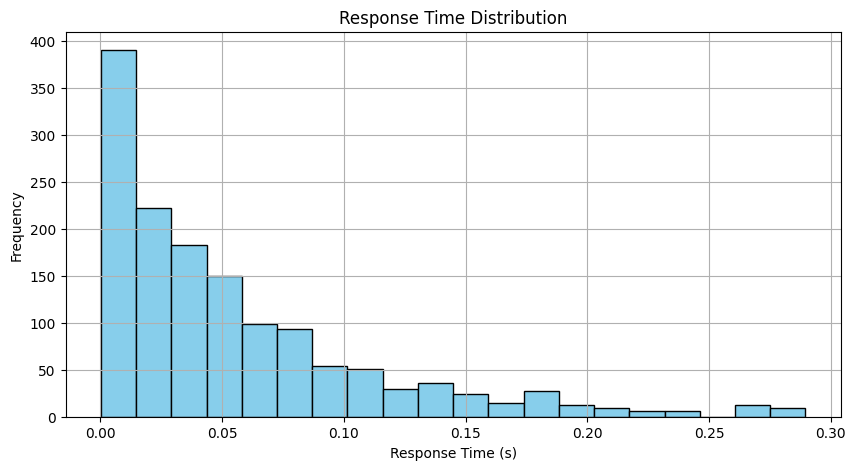

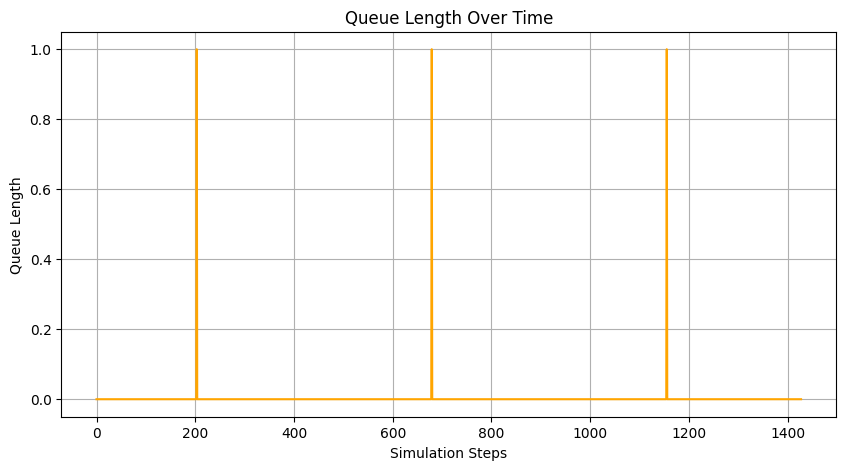

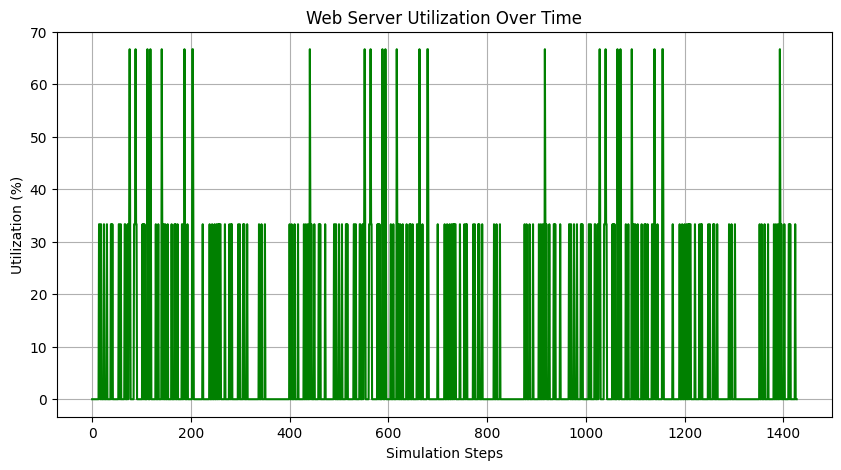

Simulation results exported to CSV files.


In [ ]:
# Execute the simulation
if __name__ == "__main__":
    main()